In [123]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib.patches as patches
import random
from shapely.geometry import Point
from copy import copy
from shapely.ops import unary_union
from time import sleep
from tqdm import tqdm

In [3]:
df = pd.read_csv("Proba.csv")
df

,har,ward,Occurances,latitude_y,longitude_y,Prob
0,0,JAGAKARSA,126,-6.324766,106.819422,0.014390
1,1,PONDOK PINANG,119,-6.273637,106.778950,0.013591
2,2,JATI PADANG,104,-6.287241,106.830545,0.011878
3,3,PENJARINGAN,99,-6.128904,106.799201,0.011307
4,4,LEBAK BULUS,99,-6.301672,106.779691,0.011307
...,...,...,...,...,...,...
256,256,GUNTUR,7,-6.208312,106.833312,0.000799
257,257,KRUKUT,7,-6.156981,106.815489,0.000799
258,258,BALI MESTER,7,-6.220472,106.866717,0.000799
259,259,GLODOK,5,-6.144840,106.813187,0.000571


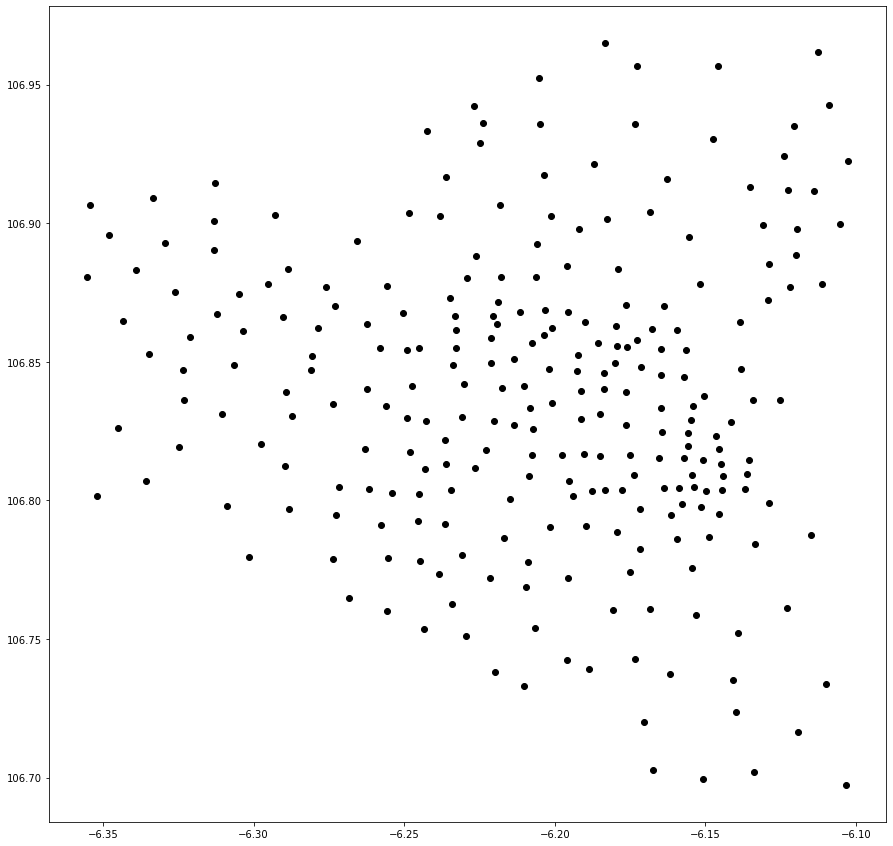

In [4]:
#visualize center coordiantes
plt.figure(figsize = [15, 15])
plt.scatter(df['latitude_y'], df['longitude_y'], c = 'black')

In [5]:
new = df[['latitude_y', 'longitude_y']].copy()
new

,latitude_y,longitude_y
0,-6.324766,106.819422
1,-6.273637,106.778950
2,-6.287241,106.830545
3,-6.128904,106.799201
4,-6.301672,106.779691
...,...,...
256,-6.208312,106.833312
257,-6.156981,106.815489
258,-6.220472,106.866717
259,-6.144840,106.813187


In [6]:
#cluster the wards with k-means
distortions = []
K = range(1,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(new)
    distortions.append(kmeanModel.inertia_)

C:\Users\GI Maximus\anaconda3\envs\advance_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


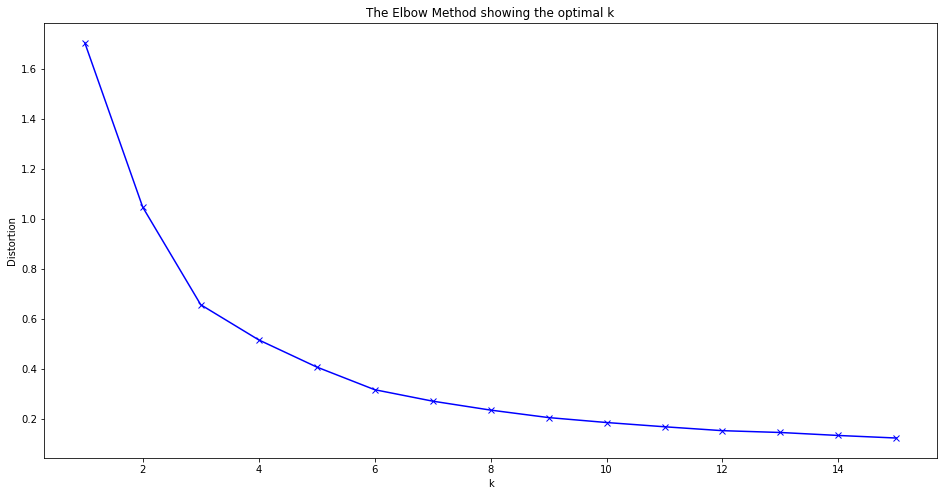

In [7]:
#elbow method for deciding number of clusters
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

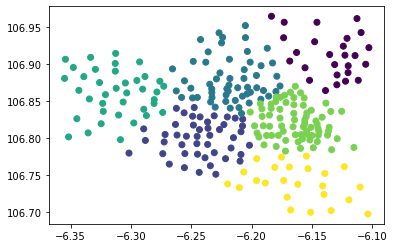

In [8]:
#6 clusters from elbow method
kmeanModel = KMeans(n_clusters=6)
fitting = kmeanModel.fit(new)
plt.scatter(new['latitude_y'], new['longitude_y'], c=kmeanModel.labels_)
plt.show()

In [9]:
#assign each ward with their cluster
new.loc[:,"Cluster"] = kmeanModel.labels_
new

,latitude_y,longitude_y,Cluster
0,-6.324766,106.819422,3
1,-6.273637,106.778950,1
2,-6.287241,106.830545,3
3,-6.128904,106.799201,4
4,-6.301672,106.779691,1
...,...,...,...
256,-6.208312,106.833312,2
257,-6.156981,106.815489,4
258,-6.220472,106.866717,2
259,-6.144840,106.813187,4


In [10]:
#integrate both probability and ward name into dataset
new['Prob']=df['Prob']
new

,latitude_y,longitude_y,Cluster,Prob
0,-6.324766,106.819422,3,0.014390
1,-6.273637,106.778950,1,0.013591
2,-6.287241,106.830545,3,0.011878
3,-6.128904,106.799201,4,0.011307
4,-6.301672,106.779691,1,0.011307
...,...,...,...,...
256,-6.208312,106.833312,2,0.000799
257,-6.156981,106.815489,4,0.000799
258,-6.220472,106.866717,2,0.000799
259,-6.144840,106.813187,4,0.000571


In [11]:
locs = new
locs['name'] = df['ward']
locs

,latitude_y,longitude_y,Cluster,Prob,name
0,-6.324766,106.819422,3,0.014390,JAGAKARSA
1,-6.273637,106.778950,1,0.013591,PONDOK PINANG
2,-6.287241,106.830545,3,0.011878,JATI PADANG
3,-6.128904,106.799201,4,0.011307,PENJARINGAN
4,-6.301672,106.779691,1,0.011307,LEBAK BULUS
...,...,...,...,...,...
256,-6.208312,106.833312,2,0.000799,GUNTUR
257,-6.156981,106.815489,4,0.000799,KRUKUT
258,-6.220472,106.866717,2,0.000799,BALI MESTER
259,-6.144840,106.813187,4,0.000571,GLODOK


In [12]:
#create a dataset of total probability of each ward
Cluster_Prob = new.groupby('Cluster')['Prob'].sum().reset_index(name='Prob')
Cluster_Prob

,Cluster,Prob
0,0,0.107469
1,1,0.206715
2,2,0.195866
3,3,0.178620
4,4,0.191754
5,5,0.119575


In [13]:
#using Cumulative Distribution Function for the probability
Cluster_Prob['Prob_CDF'] = Cluster_Prob['Prob'].cumsum()
Cluster_Prob

,Cluster,Prob,Prob_CDF
0,0,0.107469,0.107469
1,1,0.206715,0.314185
2,2,0.195866,0.510050
3,3,0.178620,0.688671
4,4,0.191754,0.880425
5,5,0.119575,1.000000


In [14]:
#generate 1000 random number between 0-1
Randf = pd.DataFrame(np.random.rand(1000, 1))
Randf.columns = ['Prob']
Randf

,Prob
0,0.443581
1,0.835053
2,0.020839
3,0.229155
4,0.085581
...,...
995,0.136742
996,0.482520
997,0.111988
998,0.044335


In [15]:
#assign each random generated number with their cluster based on the 
Randf['Category'] = pd.cut(Randf['Prob'], 
                        bins=[0, Cluster_Prob['Prob_CDF'][0], Cluster_Prob['Prob_CDF'][1], Cluster_Prob['Prob_CDF'][2],
                              Cluster_Prob['Prob_CDF'][3], Cluster_Prob['Prob_CDF'][4], Cluster_Prob['Prob_CDF'][5]], 
                        labels=['0','1','2','3', '4', '5'],
                        include_lowest=True)
Randf['Category'].value_counts()

1    216
2    207
3    175
4    166
0    119
5    117
Name: Category, dtype: int64

In [16]:
#import the polygon file of each ward
plz_shape_df = gpd.read_file('Jakarta Map.shp', dtype={'plz': str})
plz_shape_df['name'] = plz_shape_df['name'].str.upper()
plz_shape_df

,fid,id,@id,admin_leve,boundary,is_in_muni,is_in_prov,is_in_town,name,type,note,is_in_city,@relations,Clustered_,Clustere_1,geometry
0,1.0,relation/5802121,relation/5802121,7,administrative,Pademangan,DKI Jakarta,Jakarta Utara,ANCOL,boundary,None,None,None,1.0,0.005710,"POLYGON ((106.82334 -6.11568, 106.82760 -6.116..."
1,2.0,relation/5802122,relation/5802122,7,administrative,Tambora,DKI Jakarta,Jakarta Barat,PEKOJAN,boundary,None,None,None,1.0,0.002741,"POLYGON ((106.80427 -6.13241, 106.80582 -6.132..."
2,3.0,relation/5802123,relation/5802123,7,administrative,Cilincing,DKI Jakarta,Jakarta Utara,MARUNDA,boundary,None,None,None,2.0,0.002398,"POLYGON ((106.95896 -6.13234, 106.95897 -6.132..."
3,4.0,relation/5802124,relation/5802124,7,administrative,Pulo Gadung,DKI Jakarta,Jakarta Timur,KAYU PUTIH,boundary,None,None,None,4.0,0.007423,"POLYGON ((106.87588 -6.17886, 106.87592 -6.178..."
4,5.0,relation/5802125,relation/5802125,7,administrative,Koja,DKI Jakarta,Jakarta Utara,LAGOA,boundary,None,None,None,2.0,0.002627,"POLYGON ((106.90305 -6.11204, 106.90598 -6.112..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,264.0,relation/7198542,relation/7198542,7,administrative,Tebet,DKI Jakarta,Jakarta Selatan,MENTENG DALAM,boundary,None,None,None,4.0,0.004111,"POLYGON ((106.84733 -6.22898, 106.84715 -6.229..."
264,265.0,relation/7210655,relation/7210655,7,administrative,Tebet,DKI Jakarta,Jakarta Selatan,BUKIT DURI,boundary,None,None,None,4.0,0.005254,"POLYGON ((106.85894 -6.21635, 106.85915 -6.216..."
265,266.0,relation/7212530,relation/7212530,7,administrative,Menteng,DKI Jakarta,Jakarta Pusat,MENTENG,boundary,None,None,None,1.0,0.005596,"POLYGON ((106.84499 -6.20363, 106.84583 -6.204..."
266,267.0,relation/7212612,relation/7212612,7,administrative,Menteng,DKI Jakarta,Jakarta Pusat,PEGANGSAAN,boundary,None,None,None,4.0,0.002170,"POLYGON ((106.84305 -6.20089, 106.84281 -6.200..."


In [19]:
plz_shape_df1 = pd.merge(locs, 
                      plz_shape_df, 
                      on ='name', 
                      how ='left')
plz_shape_df1

,latitude_y,longitude_y,Cluster,Prob,name,fid,id,@id,admin_leve,boundary,is_in_muni,is_in_prov,is_in_town,type,note,is_in_city,@relations,Clustered_,Clustere_1,geometry
0,-6.324766,106.819422,3,0.014390,JAGAKARSA,95.0,relation/5802221,relation/5802221,7,administrative,Jagakarsa,DKI Jakarta,Jakarta Selatan,boundary,None,None,None,3.0,0.014390,"POLYGON ((106.83086 -6.33615, 106.83080 -6.336..."
1,-6.273637,106.778950,1,0.013591,PONDOK PINANG,170.0,relation/5802300,relation/5802300,7,administrative,Kebayoran Lama,DKI Jakarta,Jakarta Selatan,boundary,None,None,None,0.0,0.013591,"POLYGON ((106.76937 -6.27805, 106.76978 -6.278..."
2,-6.287241,106.830545,3,0.011878,JATI PADANG,185.0,relation/5802316,relation/5802316,7,administrative,Pasar Minggu,DKI Jakarta,Jakarta Selatan,boundary,None,None,None,3.0,0.011878,"POLYGON ((106.82961 -6.27960, 106.83150 -6.278..."
3,-6.128904,106.799201,4,0.011307,PENJARINGAN,255.0,relation/5802387,relation/5802387,7,administrative,Penjaringan,DKI Jakarta,Jakarta Utara,boundary,None,None,None,1.0,0.011307,"POLYGON ((106.80708 -6.13170, 106.80639 -6.131..."
4,-6.301672,106.779691,1,0.011307,LEBAK BULUS,207.0,relation/5802338,relation/5802338,7,administrative,Cilandak,DKI Jakarta,Jakarta Selatan,boundary,None,None,None,0.0,0.011307,"POLYGON ((106.77261 -6.30028, 106.77249 -6.300..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,-6.208312,106.833312,2,0.000799,GUNTUR,166.0,relation/5802296,relation/5802296,7,administrative,Setiabudi,DKI Jakarta,Jakarta Selatan,boundary,None,None,None,1.0,0.000799,"POLYGON ((106.82916 -6.20668, 106.82901 -6.206..."
257,-6.156981,106.815489,4,0.000799,KRUKUT,42.0,relation/5802166,relation/5802166,7,administrative,Taman Sari,DKI Jakarta,Jakarta Barat,boundary,None,None,None,1.0,0.000799,"POLYGON ((106.81111 -6.15550, 106.81113 -6.155..."
258,-6.220472,106.866717,2,0.000799,BALI MESTER,20.0,relation/5802141,relation/5802141,7,administrative,Jatinegara,DKI Jakarta,Jakarta Timur,boundary,None,None,None,4.0,0.000799,"POLYGON ((106.86690 -6.22562, 106.86673 -6.225..."
259,-6.144840,106.813187,4,0.000571,GLODOK,134.0,relation/5802262,relation/5802262,7,administrative,Taman Sari,DKI Jakarta,Jakarta Barat,boundary,None,None,None,1.0,0.000571,"POLYGON ((106.81588 -6.14633, 106.81640 -6.148..."


In [21]:
plz_shape_df2 = pd.merge(plz_shape_df, 
                         locs,                      
                      on ='name', 
                      how ='left')
plz_shape_df2

,fid,id,@id,admin_leve,boundary,is_in_muni,is_in_prov,is_in_town,name,type,note,is_in_city,@relations,Clustered_,Clustere_1,geometry,latitude_y,longitude_y,Cluster,Prob
0,1.0,relation/5802121,relation/5802121,7,administrative,Pademangan,DKI Jakarta,Jakarta Utara,ANCOL,boundary,None,None,None,1.0,0.005710,"POLYGON ((106.82334 -6.11568, 106.82760 -6.116...",-6.125215,106.836247,4.0,0.005710
1,2.0,relation/5802122,relation/5802122,7,administrative,Tambora,DKI Jakarta,Jakarta Barat,PEKOJAN,boundary,None,None,None,1.0,0.002741,"POLYGON ((106.80427 -6.13241, 106.80582 -6.132...",-6.136967,106.804024,4.0,0.002741
2,3.0,relation/5802123,relation/5802123,7,administrative,Cilincing,DKI Jakarta,Jakarta Utara,MARUNDA,boundary,None,None,None,2.0,0.002398,"POLYGON ((106.95896 -6.13234, 106.95897 -6.132...",-6.112490,106.961717,0.0,0.002398
3,4.0,relation/5802124,relation/5802124,7,administrative,Pulo Gadung,DKI Jakarta,Jakarta Timur,KAYU PUTIH,boundary,None,None,None,4.0,0.007423,"POLYGON ((106.87588 -6.17886, 106.87592 -6.178...",-6.179006,106.883675,2.0,0.007423
4,5.0,relation/5802125,relation/5802125,7,administrative,Koja,DKI Jakarta,Jakarta Utara,LAGOA,boundary,None,None,None,2.0,0.002627,"POLYGON ((106.90305 -6.11204, 106.90598 -6.112...",-6.114100,106.911646,0.0,0.002627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,264.0,relation/7198542,relation/7198542,7,administrative,Tebet,DKI Jakarta,Jakarta Selatan,MENTENG DALAM,boundary,None,None,None,4.0,0.004111,"POLYGON ((106.84733 -6.22898, 106.84715 -6.229...",-6.230139,106.841882,2.0,0.004111
264,265.0,relation/7210655,relation/7210655,7,administrative,Tebet,DKI Jakarta,Jakarta Selatan,BUKIT DURI,boundary,None,None,None,4.0,0.005254,"POLYGON ((106.85894 -6.21635, 106.85915 -6.216...",-6.221095,106.858426,2.0,0.005254
265,266.0,relation/7212530,relation/7212530,7,administrative,Menteng,DKI Jakarta,Jakarta Pusat,MENTENG,boundary,None,None,None,1.0,0.005596,"POLYGON ((106.84499 -6.20363, 106.84583 -6.204...",-6.201046,106.835211,4.0,0.005596
266,267.0,relation/7212612,relation/7212612,7,administrative,Menteng,DKI Jakarta,Jakarta Pusat,PEGANGSAAN,boundary,None,None,None,4.0,0.002170,"POLYGON ((106.84305 -6.20089, 106.84281 -6.200...",-6.201950,106.847491,2.0,0.002170


In [22]:
plz_shape_df1.to_csv('testing.csv', index=False)

In [23]:
plz_shape_df1.dtypes

latitude_y      float64
longitude_y     float64
Cluster           int32
Prob            float64
name             object
fid             float64
id               object
@id              object
admin_leve       object
boundary         object
is_in_muni       object
is_in_prov       object
is_in_town       object
type             object
note             object
is_in_city       object
@relations       object
Clustered_      float64
Clustere_1      float64
geometry       geometry
dtype: object

In [24]:
#create a function that would generate the map of each cluster
def generate_random_location_within_ROI(num_pt, polygon):
  """
  Generate num_pt random location coordinates .
  :param num_pt INT number of random location coordinates
  :param polygon geopandas.geoseries.GeoSeries the polygon of the region
  :return x, y lists of location coordinates, longetude and latitude
  """
  # define boundaries
  bounds_all = polygon.bounds
  minx = min(bounds_all.minx)
  maxx = max(bounds_all.maxx)
  miny = min(bounds_all.miny)
  maxy = max(bounds_all.maxy)

  i = 0
  x = []
  y = []
  while i < num_pt:
    # generate random location coordinates
    x_t = np.random.uniform(minx, maxx)
    y_t = np.random.uniform(miny, maxy)
    # further check whether it is in the city area 
    for p in polygon:
      if Point(x_t, y_t).within(p):
        x.append(x_t)
        y.append(y_t)
        i = i + 1
        break

  return x, y

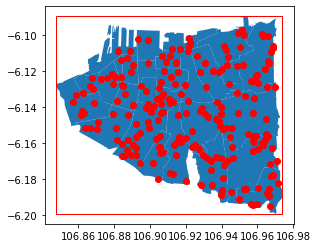

In [26]:
#testing the function on a cluster
Cluster0 = plz_shape_df2[plz_shape_df2.Cluster == 0 ]
Cluster0_Plot = Cluster0["geometry"]
x, y = generate_random_location_within_ROI(Randf['Category'].value_counts()[0], Cluster0_Plot)
bounds_all = Cluster0["geometry"].bounds
minx = min(bounds_all.minx)
maxx = max(bounds_all.maxx)
miny = min(bounds_all.miny)
maxy = max(bounds_all.maxy)
ax = Cluster0_Plot.plot()

rect = patches.Rectangle((minx, miny), maxx-minx, maxy-miny, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.plot(x, y, "ro")
plt.show()

In [27]:
#create a function that would generate random points using the CDF model created
def polygon_random_points (poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
                random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
                if (random_point.within(poly)):
                    points.append(random_point)
    return points

In [120]:

# Cluster = {}
# Cluster_Plot = {}
# ClusterCombine = {}
# points = {}
# coor = {}
# dft = {}
# writer = pd.ExcelWriter('Output1.xlsx')
# for i in range(6):
#         Cluster[str(i)] = []
#         Cluster[str(i)] = plz_shape_df2[plz_shape_df2.Cluster == i ]
#         Cluster_Plot[str(i)] = Cluster[str(i)]["geometry"]
#         ClusterCombine[str(i)] = Cluster[str(i)].dissolve(by='Cluster')
#         ClusterCombine[str(i)]["geometry"].iloc[0]
#         points[str(i)] = polygon_random_points(ClusterCombine[str(i)]["geometry"].iloc[0],Randf[Randf.Category == str(i)].shape[0])
#         coor[str(i)] =[]
#         for p in points[str(i)]:
#             coor[str(i)].append((p.x,p.y))
#         dft[str(i)] = pd.DataFrame(coor[str(i)])
#         dft[str(i)].to_excel(writer, sheet_name=str(i))
# writer.save()

In [119]:
dft[str(0)]

,0,1
0,106.867555,-6.157118
1,106.931924,-6.169858
2,106.865588,-6.143321
3,106.895956,-6.119665
4,106.954068,-6.128646
...,...,...
114,106.902922,-6.116686
115,106.963410,-6.114711
116,106.916150,-6.132832
117,106.888232,-6.159980


In [126]:
#create a function that will generate 1000 simulations with 1000 points for each simulations
Cluster = {}
Cluster_Plot = {}
ClusterCombine = {}
points = {}
coor = {}
dft = {}
writer = pd.ExcelWriter('Output1.xlsx')
for j in tqdm(range(1000)):
    dataset = []
    for i in range(6):
            Cluster[str(i)] = []
            Cluster[str(i)] = plz_shape_df2[plz_shape_df2.Cluster == i ]
            Cluster_Plot[str(i)] = Cluster[str(i)]["geometry"]
            ClusterCombine[str(i)] = Cluster[str(i)].dissolve(by='Cluster')
            ClusterCombine[str(i)]["geometry"].iloc[0]
            points[str(i)] = polygon_random_points(ClusterCombine[str(i)]["geometry"].iloc[0],Randf[Randf.Category == str(i)].shape[0])
            coor[str(i)] =[]
            for p in points[str(i)]:
                coor[str(i)].append((p.x,p.y))
            dft[str(i)] = pd.DataFrame(coor[str(i)])
            dft[str(i)].to_csv(writer, sheet_name=str(j) + str(i))
    
writer.save()

100%|██████████| 1000/1000 [10:54<00:00,  1.53it/s]
